1) Read in all files
2) See how many 0's, 1's
3) Analyze file (see the average length) 

In [1]:
import os

replay_path = "c:\\data\\label\\"
for dirName, subdirList, fileList in os.walk(replay_path):
    zeros = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '0']
    ones = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '1']
print(f"Zeros: {len(zeros)}\nOnes: {len(ones)}")
    

Zeros: 38
Ones: 37


In [2]:
import pandas as pd

all_files = zeros + ones
file_lengths = []
for f in all_files:
    df = pd.read_csv(os.path.join(replay_path,f))
    file_lengths.append(df.shape[0])
pd.Series(file_lengths).describe()


count     75.000000
mean     633.386667
std      142.635795
min      295.000000
25%      544.500000
50%      646.000000
75%      751.000000
max      848.000000
dtype: float64

4) For each file, take 5 seconds before and 1 second after the event of interest (sampling every 0.5 seconds)

In [3]:
sample_interval = 0.5
seconds_before = 5
seconds_after = 1

all_seqs = []
for file in all_files:
    df = pd.read_csv(os.path.join(replay_path,file),index_col=0)
    min_dist = df['hausdorff_distance'].min()
    min_dist_idx = df['hausdorff_distance'].idxmin()
    start_idx = min_dist_idx - seconds_before * (2*sample_interval/0.05)
    stop_idx = min_dist_idx + seconds_after * (2*sample_interval/0.05)

    indices_to_sample = []
    for x in range(int(start_idx),int(stop_idx+1),int(sample_interval/0.05)): indices_to_sample.append(x)

    columns_of_interest = ['hausdorff_distance','angle',
        'ego_vel_x','ego_vel_y','ego_vel_z','ego_accel_x','ego_accel_y','ego_accel_z','ego_ang_vel_x','ego_ang_vel_y','ego_ang_vel_z',
        'adv_vel_x','adv_vel_y','adv_vel_z','adv_accel_x','adv_accel_y','adv_accel_z','adv_ang_vel_x','adv_ang_vel_y','adv_ang_vel_z']
    rows_of_interest = df.loc[indices_to_sample,columns_of_interest]
    one_seq = []
    for index, rows in rows_of_interest.iterrows():
        for elem in rows:
            one_seq.append(elem)
    one_seq.append(file.split(".csv")[0].split("_",2)[2])
    all_seqs.append(one_seq)

full_df = pd.DataFrame(all_seqs, columns=(columns_of_interest * 13 + ['class']))
full_df.to_csv("c:\\data\\labeled_data.csv",index=None)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Columns: 261 entries, hausdorff_distance to class
dtypes: float64(260), object(1)
memory usage: 153.1+ KB


5) Generate Train/Test Files

In [4]:
from sklearn.model_selection import train_test_split
x = full_df.iloc[:,:-1]
y = full_df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)
train = x_train.assign(Class=y_train)
test = x_test.assign(Class=y_test)
train.to_csv('c:\\data\\train_file.csv',index=None)
test.to_csv('c:\\data\\test_file.csv',index=None)


In [5]:
x_train.head()

,hausdorff_distance,angle,ego_vel_x,ego_vel_y,ego_vel_z,ego_accel_x,ego_accel_y,ego_accel_z,ego_ang_vel_x,ego_ang_vel_y,...,ego_ang_vel_z,adv_vel_x,adv_vel_y,adv_vel_z,adv_accel_x,adv_accel_y,adv_accel_z,adv_ang_vel_x,adv_ang_vel_y,adv_ang_vel_z
49,25.529784,-1.145073,-2.711608,0.373176,-0.012496,1.147561,-0.238007,0.008906,0.505303,0.971019,...,-5.928018,3.180271,0.027457,0.000351,-1.912751,-0.017841,0.003745,-0.057418,0.292282,-1.286626
61,0.635964,-151.562621,0.289962,1.558689,0.003126,0.072213,0.011597,0.002280,0.002658,0.003527,...,-0.029528,0.016301,1.648964,0.004950,0.179842,-1.639903,0.024406,0.368965,0.142480,-1.071043
51,22.884587,2.053052,-2.618435,0.615499,0.000161,-1.451879,0.277530,-0.002411,0.538800,-0.540214,...,-3.745650,2.986934,0.015360,0.000468,-0.003419,0.008574,0.011269,-0.074295,-0.025973,0.119991
24,8.526672,22.055940,-2.226957,1.315113,0.005590,0.978084,-0.730054,0.007896,0.609201,0.348161,...,-0.000042,0.121638,2.793959,0.005972,0.000319,-0.000072,-0.000033,-0.000132,0.000337,-0.212651
63,9.790692,-321.060574,-0.007567,-2.692872,0.000802,-0.008035,-1.553245,0.015298,0.488834,-0.072028,...,-0.521310,-1.274037,-0.009542,-0.001148,-0.308323,-0.009125,-0.001403,-0.025819,0.035490,-1.285690


In [6]:
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

RF = RandomForestClassifier()
RF.fit(x_train,y_train)
RF.score(x_test,y_test)

0.92

[(220, 'hausdorff_distance', 0.12800815686689362), (160, 'hausdorff_distance', 0.10587692311428917), (200, 'hausdorff_distance', 0.05349283827857041), (140, 'hausdorff_distance', 0.05118704983012105), (101, 'angle', 0.04473493033519527), (240, 'hausdorff_distance', 0.042626011128634816), (120, 'hausdorff_distance', 0.04097350271670854), (180, 'hausdorff_distance', 0.03411465543644414), (81, 'angle', 0.033836783678907946), (173, 'adv_vel_z', 0.03351163818850482)]
56.15384615384615


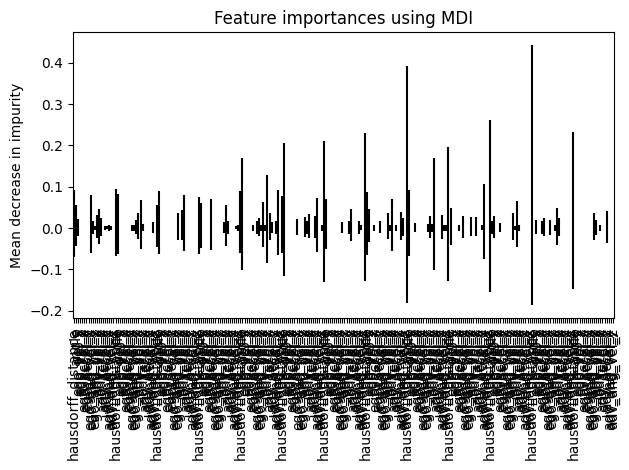

In [8]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
feature_names=x_test.columns.values.tolist()
forest_importances = pd.Series(importances, index=feature_names)

#print(np.sort(importances)[::-1])
sorted_importances = np.argsort(importances)[::-1]
sorted_tuple = [(i,feature_names[i],importances[i]) for i in sorted_importances]
print(sorted_tuple[:10])
print(len([x for x in sorted_tuple if x[2]==0])/len(sorted_tuple) * 100)



forest_importances.to_csv("forest_importance.csv")

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std,ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


